In [438]:
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
#plt.style.use('seaborn')
plt.style.use('seaborn-v0_8-whitegrid')

mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

#from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


In [439]:
# for OS of Google Golab and reading CSV file
from google.colab import drive
import os # for Operating System functions

In [440]:
# Mount google drive , this will ask for your credentials
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [441]:
curdirpath = '/content/drive/My Drive/UOA_GreatLearning/25_Y2_CSC_696H_SP_24_001/05_Project/Data'
os.chdir(curdirpath)

In [442]:
os.getcwd()

'/content/drive/My Drive/UOA_GreatLearning/25_Y2_CSC_696H_SP_24_001/05_Project/Data'

Initialize Parameters

In [443]:
# inputfilename = "HILTON_2.csv"
# inputfilename = "HILTON_2_CSV_utf.csv"
# inputfilename = "HILTON_2_CSV.csv"
# inputfilename = "HILTON_2_CSV_MSDOS.csv"
inputfilename = "HILTON.csv"
# inputfilename = "AARVI.csv"

startdate = '2022-05-02'
enddate ='2024-09-20'
frequency = 'B' # 'B' for business days
stocksymbol = "HILTON"
selectedrowpercentage = 1 # Percentage of rows seleceted from the total rows read from the data file
testdatapercentage = 0.5 # Percentage of rows used as test data ( out of selected rows ), SelectedRows - TestData  = TrainingData
lookback = 200 # choose sequence length
forcastdays = 60 # choose number of days to forcaste in future
epochcount = 150

Function : Read Multiple stock data in a loop

<ipython-input-444-ad752026105a>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_SingleStock=pd.read_csv(inputfilename, index_col='Date',


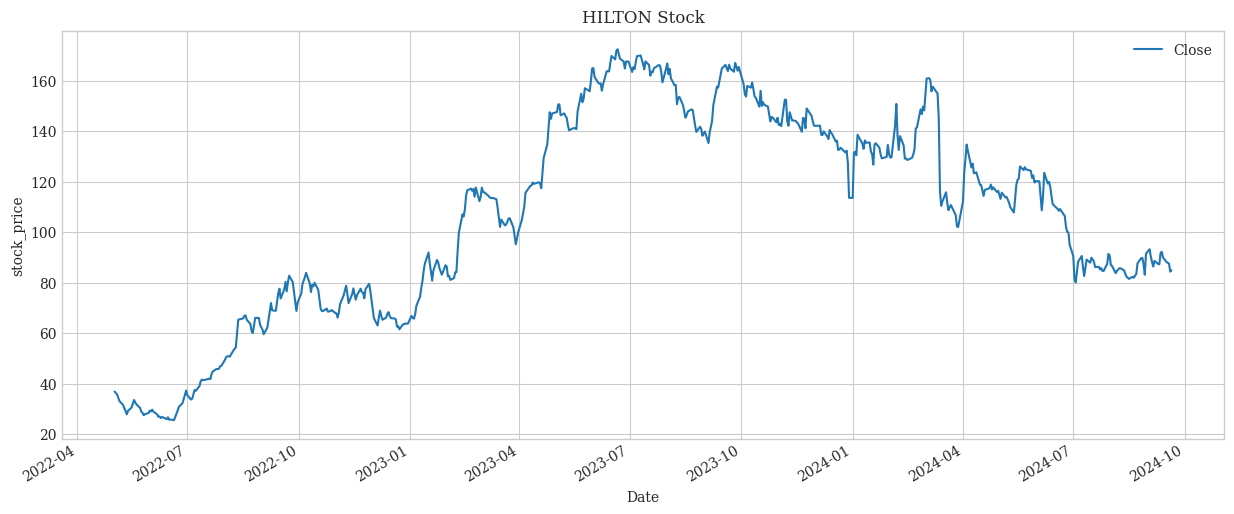

In [444]:
# dates = pd.date_range(startdate,enddate,freq=frequency)
# df1=pd.DataFrame(index=dates)

df_SingleStock=pd.read_csv(inputfilename, index_col='Date',
                           parse_dates=True,usecols=['Stock','Date','Open','High','Low','Close','Volume'],na_values=['nan'])

# df_SingleStock=pd.read_csv(inputfilename, index_col='Date',
#                            parse_dates=True,na_values=['nan']) # This is an alternate working syntax

df_SingleStock.head()
# df_SingleStock.fillna(method='ffill')

df_SingleStock[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title(stocksymbol + " Stock")
plt.show()

In [445]:
# Get Status of the Dataframe

print ("Number of Rows : ", df_SingleStock.shape[0])
print ("Number of Rows with at least one Nan / missing value " , df_SingleStock.isna().any(axis=1).sum(), " =  " , round(df_SingleStock.isna().any(axis=1).sum()/ df_SingleStock.shape[0],2)*100 , "% ")
print ("Number of Rows with NO Nan / missing value " ,  df_SingleStock.notna().all(axis=1).sum(), " =  " , round(df_SingleStock.notna().all(axis=1).sum()/ df_SingleStock.shape[0],2)*100 , "% ")
print ("Number of Columns : ", df_SingleStock.shape[1])
print ("Column names: " , df_SingleStock.columns.tolist())
df_SingleStock.head()

Number of Rows :  593
Number of Rows with at least one Nan / missing value  0  =   0.0 % 
Number of Rows with NO Nan / missing value  593  =   100.0 % 
Number of Columns :  6
Column names:  ['Stock', 'Open', 'High', 'Low', 'Close', 'Volume']


,Stock,Open,High,Low,Close,Volume
Date,,,,,,
2024-09-20,HILTON,84.14,87.00,84.14,84.87,100625
2024-09-19,HILTON,87.50,88.00,83.72,84.34,190045
2024-09-18,HILTON,88.00,88.73,84.96,87.50,204601
2024-09-17,HILTON,88.24,90.90,87.50,87.82,171564
2024-09-16,HILTON,90.01,90.80,87.10,88.10,209499


In [446]:
# Sort Data frame in Assending order for Date
df_Sorted = df_SingleStock.sort_values(by='Date',ascending = True)
df_SingleStock = df_Sorted

# Check the Sorted data frame
df_SingleStock.head()

,Stock,Open,High,Low,Close,Volume
Date,,,,,,
2022-05-02,HILTON,36.55,37.25,35.05,36.85,6093
2022-05-04,HILTON,35.35,36.70,35.10,35.70,15784
2022-05-05,HILTON,35.10,35.10,34.15,34.35,11466
2022-05-06,HILTON,32.85,34.35,32.75,33.05,5906
2022-05-09,HILTON,31.50,34.45,31.40,31.50,17513


In [447]:
# # Split train and test data before MinMaxScaler , to check the data in actual input values.
selected_row_count = int(np.round(len(df_SingleStock)*selectedrowpercentage))
df_SingleStock = df_SingleStock[:selected_row_count]

print("Selected Row count ",selected_row_count)

Selected Row count  593


In [448]:
# Get Status of the Dataframe

print ("Number of Rows : ", df_SingleStock.shape[0])
print ("Number of Rows with at least one Nan / missing value " , df_SingleStock.isna().any(axis=1).sum(), " =  " , round(df_SingleStock.isna().any(axis=1).sum()/ df_SingleStock.shape[0],2)*100 , "% ")
print ("Number of Rows with NO Nan / missing value " ,  df_SingleStock.notna().all(axis=1).sum(), " =  " , round(df_SingleStock.notna().all(axis=1).sum()/ df_SingleStock.shape[0],2)*100 , "% ")
print ("Number of Columns : ", df_SingleStock.shape[1])
print ("Column names: " , df_SingleStock.columns.tolist())
df_SingleStock.head()

Number of Rows :  593
Number of Rows with at least one Nan / missing value  0  =   0.0 % 
Number of Rows with NO Nan / missing value  593  =   100.0 % 
Number of Columns :  6
Column names:  ['Stock', 'Open', 'High', 'Low', 'Close', 'Volume']


,Stock,Open,High,Low,Close,Volume
Date,,,,,,
2022-05-02,HILTON,36.55,37.25,35.05,36.85,6093
2022-05-04,HILTON,35.35,36.70,35.10,35.70,15784
2022-05-05,HILTON,35.10,35.10,34.15,34.35,11466
2022-05-06,HILTON,32.85,34.35,32.75,33.05,5906
2022-05-09,HILTON,31.50,34.45,31.40,31.50,17513


In [449]:
# Fill Columns with NaN, NO BLANK COLUMNS are there in the data frame here onwards
df_SingleStock=df_SingleStock.fillna(method='ffill')
df_SingleStock_org = df_SingleStock.copy() # Safe keep the Original data

scaler = MinMaxScaler(feature_range=(-1, 1))
df_SingleStock['Close'] = scaler.fit_transform(df_SingleStock['Close'].values.reshape(-1,1))

<ipython-input-449-3aab1737a73c>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_SingleStock=df_SingleStock.fillna(method='ffill')


In [450]:
print ("Number of Rows : ", df_SingleStock.shape[0])
print(df_SingleStock.head())

Number of Rows :  593
             Stock   Open   High    Low     Close  Volume
Date                                                     
2022-05-02  HILTON  36.55  37.25  35.05 -0.845473    6093
2022-05-04  HILTON  35.35  36.70  35.10 -0.861130   15784
2022-05-05  HILTON  35.10  35.10  34.15 -0.879510   11466
2022-05-06  HILTON  32.85  34.35  32.75 -0.897209    5906
2022-05-09  HILTON  31.50  34.45  31.40 -0.918312   17513


In [451]:
df_SingleStock=df_SingleStock[['Close']]
df_SingleStock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 593 entries, 2022-05-02 to 2024-09-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   593 non-null    float64
dtypes: float64(1)
memory usage: 9.3 KB


In [452]:
# # function to create train, test data given stock data and sequence length
# def load_data(stock, look_back):
#     data_raw = stock.values # convert to numpy array
#     print("Print Stock input parameter")
#     # print(stock)
#     print("Print data_raw : Stock Values")
#     # print(data_raw)
#     data = []

#     # create all possible sequences of length look_back
#     for index in range(len(data_raw) - look_back):
#         data.append(data_raw[index: index + look_back])

#     total_row_count = int(len(data))
#     print("Total Row count ",total_row_count)

#     # selected_row_count = int(np.round(len(data)*selectedrowpercentage))
#     # # selected_row_count = int(np.round(len(data)*0.5))
#     # print("Selected Row count ",selected_row_count)
#     # data = data[:selected_row_count]

#     data = np.array(data);

#     # print(data)
#     test_set_size = int(np.round(testdatapercentage*data.shape[0]));
#     # test_set_size = int(np.round(0.80*data.shape[0]));
#     train_set_size = data.shape[0] - (test_set_size);


#     # x_train = data[:100]
#     # y_train = data[:100]

#     x_train = data[:train_set_size,:-1,:]
#     y_train = data[:train_set_size,-1,:]

#     # x_train = data[:train_set_size,:-1,:]
#     # y_train = data[:train_set_size,-1,:]

#     x_test = data[train_set_size:,:-1]
#     y_test = data[train_set_size:,-1,:]

#     return [data,x_train, y_train, x_test, y_test]




In [453]:
def split_testing_training_data(data,testdatapercentage):

    test_set_size = int(np.round(testdatapercentage*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    train_data = data[:train_set_size]
    test_data = data[train_set_size:]

    return [train_data,test_data]


In [454]:
def load_data_new(stock_data,look_back):
  data_raw = stock_data.values # convert to numpy array

  # lstdata = []

  # # create all possible sequences of length look_back
  # for index in range(len(data_raw) - look_back):
  #     lstdata.append(data_raw[index: index + look_back])


  data_x = []
  data_y = []
  n_future = 1
  n_past = look_back

  for index in range(n_past,len(data_raw)-n_future+1):
    data_x.append(data_raw[index - n_past: index,0:data_raw.shape[1]])
    data_y.append(data_raw[index + n_future-1: index + n_future, 0])

  trainx,trainy = np.array(data_x),np.array(data_y)

  return [trainx,trainy]

  # lstdata.append(data_raw[index: index + look_back])


  # arrdata = np.array(lstdata);

  # set_size = len(arrdata)

  # x_data = arrdata[:set_size,:-1,:]
  # y_data = arrdata[:set_size,-1,:]

  # # df_data = pd.DataFrame(arrdata)
  # return [arrdata,x_data, y_data]


In [455]:

look_back = lookback # choose sequence length
# look_back = 60 # choose sequence length
# data, x_train, y_train, x_test, y_test = load_data(df_SingleStock, look_back)
#x_train, y_train, x_test, y_test = load_data(df_SingleStock, look_back)

print('Total Data.Rows = ' , df_SingleStock.shape[0])
print('Total Data.Cols = ' , df_SingleStock.shape[1])

df_train,df_test = split_testing_training_data(df_SingleStock,testdatapercentage)


x_train, y_train = load_data_new(df_train, look_back)
x_test, y_test = load_data_new(df_test, look_back)

# df_training, x_train, y_train = load_data_new(df_train, look_back)
# df_testing, x_test, y_test = load_data_new(df_test, look_back)


print('train.shape = ',df_train.shape)
print('test.shape = ',df_test.shape)

# print('data training = ',len(df_training))
# print('data testing = ',len(df_testing))

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

print (df_train)

Total Data.Rows =  593
Total Data.Cols =  1
train.shape =  (297, 1)
test.shape =  (296, 1)
x_train.shape =  (97, 200, 1)
y_train.shape =  (97, 1)
x_test.shape =  (96, 200, 1)
y_test.shape =  (96, 1)
               Close
Date                
2022-05-02 -0.845473
2022-05-04 -0.861130
2022-05-05 -0.879510
2022-05-06 -0.897209
2022-05-09 -0.918312
...              ...
2023-07-06  0.931246
2023-07-07  0.962560
2023-07-10  0.966644
2023-07-11  0.943499
2023-07-12  0.920354

[297 rows x 1 columns]


In [456]:
# print ("x-train :" , torch.tensor.numpy(x_train) ," y-train :" , type(y_train))

In [457]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [458]:
print (y_train.size(),x_train.size())
print (y_test.size(),x_test.size())

torch.Size([97, 1]) torch.Size([97, 200, 1])
torch.Size([96, 1]) torch.Size([96, 200, 1])


In [459]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [460]:
# Train model
#####################
num_epochs = epochcount
# num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.10467787086963654
Epoch  20 MSE:  0.028360413387417793
Epoch  30 MSE:  0.009850751608610153
Epoch  40 MSE:  0.009833777323365211
Epoch  50 MSE:  0.007734806276857853
Epoch  60 MSE:  0.006545585580170155
Epoch  70 MSE:  0.005883784499019384
Epoch  80 MSE:  0.00534629262983799
Epoch  90 MSE:  0.004894910380244255
Epoch  100 MSE:  0.004514879081398249
Epoch  110 MSE:  0.004196614492684603
Epoch  120 MSE:  0.0039294203743338585
Epoch  130 MSE:  0.00369103136472404
Epoch  140 MSE:  0.0034615013282746077


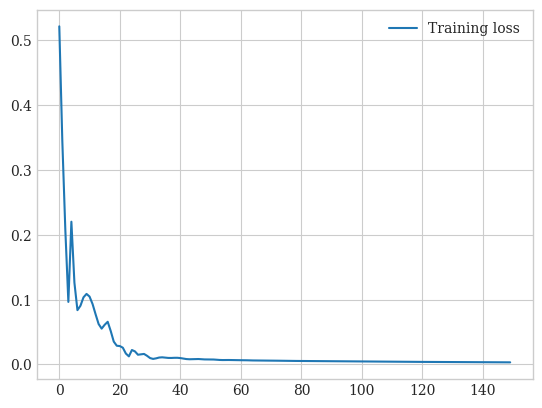

In [461]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [462]:
np.shape(y_train_pred)

torch.Size([97, 1])

In [463]:
# FORCASTING

# print ("data frame : ",df_SingleStock.tail())

forcast_days = forcastdays

last_sequence = df_SingleStock[-look_back:].values.reshape(1,look_back,1)
last_sequence_tensor = torch.from_numpy(last_sequence).type(torch.Tensor)

# print("Last sequence start : ", last_sequence)
# print("Last tensor size : " , last_sequence_tensor.size())
# print("Last sequence tensor : ", last_sequence_tensor)



model.eval()
forcasted_future = []


for i in range(forcast_days):
  with torch.no_grad():

    # last_sequence = df_SingleStock[-look_back:].values.reshape(1,look_back,1)
    # last_sequence_tensor = torch.from_numpy(last_sequence).type(torch.Tensor)


    next_pred = model(last_sequence_tensor)
    next_pred = next_pred.detach().numpy()

    forcasted_future.append(next_pred.item())
    # print ("Predicted Future :" ,predicted_future)

    last_sequence = np.roll(last_sequence,-1)
    # print ("last sequence after roll : round ",i , " val : ", last_sequence)

    # print ("New Prediction :" ,next_pred, " next pred Item ", next_pred.item())

    last_sequence[0,-1,0] = next_pred.item()
    # print ("last sequence item : round ", i ," val : " , last_sequence)

    last_sequence_tensor = torch.from_numpy(last_sequence).type(torch.Tensor)

    stockprice = scaler.inverse_transform(np.array(next_pred).reshape(-1,1))
    future_dates = pd.date_range(list(df_SingleStock.index)[-1], periods=forcast_days, freq=frequency).tolist()
    # print(" Future dates : "  ,future_dates)
    # print(" Stock Price after inverse :", stockprice)

forcasted_future = scaler.inverse_transform(np.array(forcasted_future).reshape(-1,1))
future_dates = pd.date_range(list(df_SingleStock.index)[-1], periods=forcast_days+1, freq=frequency).tolist()[1:]
forecasted_df = pd.DataFrame(forcasted_future, columns=['Close'], index=future_dates)


print( " data frame stock data ", df_SingleStock_org)
print(" data frame Pedicted: " ,forecasted_df)




 data frame stock data               Stock   Open   High    Low  Close  Volume
Date                                                  
2022-05-02  HILTON  36.55  37.25  35.05  36.85    6093
2022-05-04  HILTON  35.35  36.70  35.10  35.70   15784
2022-05-05  HILTON  35.10  35.10  34.15  34.35   11466
2022-05-06  HILTON  32.85  34.35  32.75  33.05    5906
2022-05-09  HILTON  31.50  34.45  31.40  31.50   17513
...            ...    ...    ...    ...    ...     ...
2024-09-16  HILTON  90.01  90.80  87.10  88.10  209499
2024-09-17  HILTON  88.24  90.90  87.50  87.82  171564
2024-09-18  HILTON  88.00  88.73  84.96  87.50  204601
2024-09-19  HILTON  87.50  88.00  83.72  84.34  190045
2024-09-20  HILTON  84.14  87.00  84.14  84.87  100625

[593 rows x 6 columns]
 data frame Pedicted:                   Close
2024-09-23   92.144010
2024-09-24   93.137732
2024-09-25   95.117446
2024-09-26   97.429593
2024-09-27   99.744530
2024-09-30  101.914122
2024-10-01  103.881817
2024-10-02  105.634740
2024-10

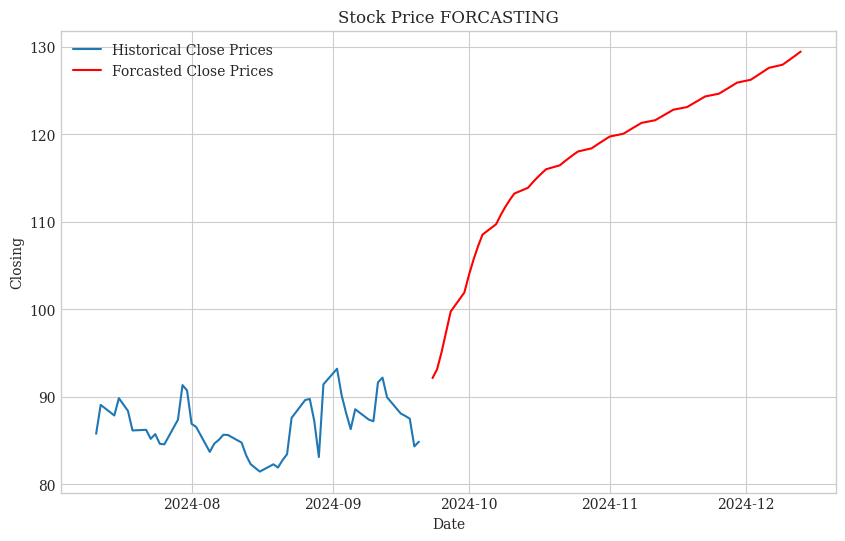

In [464]:
# Visualize the future predictions
plt.figure(figsize=(10, 6))
plt.plot(df_SingleStock_org.index[-50:], df_SingleStock_org['Close'][-50:], label='Historical Close Prices')
plt.plot(forecasted_df.index, forecasted_df['Close'], label='Forcasted Close Prices', color='red')
plt.title('Stock Price FORCASTING')
plt.xlabel('Date')
plt.ylabel('Closing')
plt.legend()
plt.show()


In [465]:
# make predictions
# print ("test data type : ", type(x_test))

y_test_pred = model(x_test)

print ("Test Lenght : " ,x_test.numel())
print ("Pridiction Length : " ,y_test_pred.numel())

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())


# Error statement predicted_df = pd.DataFrame(y_test_pred, columns=['Close'], index=df_SingleStock_org['Date'])

print (predicted_df)


Test Lenght :  19200
Pridiction Length :  96
                Close
2024-09-23  84.923997
2024-09-24  84.670067
2024-09-25  84.661774
2024-09-26  84.757770
2024-09-27  84.914792
2024-09-30  85.113564
2024-10-01  85.341594
2024-10-02  85.589793
2024-10-03  85.851614
2024-10-04  86.122473


In [466]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.19 RMSE
Test Score: 6.57 RMSE


In [467]:
# df_SingleStock['Close']
# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
# forcast_dates = []


Text(0.5, 1.0, 'Training Stock Price - HILTON')

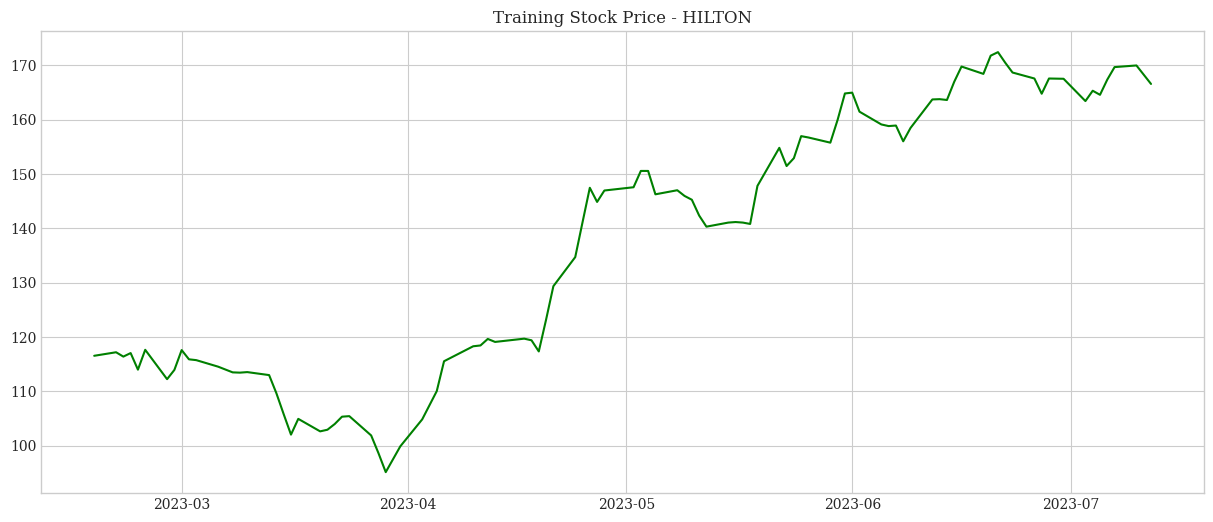

In [468]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_SingleStock[look_back:len(df_train)].index, y_train, color = 'green', label = 'Training Stock Price')
plt.title('Training Stock Price - ' + stocksymbol)



Text(0.5, 1.0, 'Test Stock Price - HILTON')

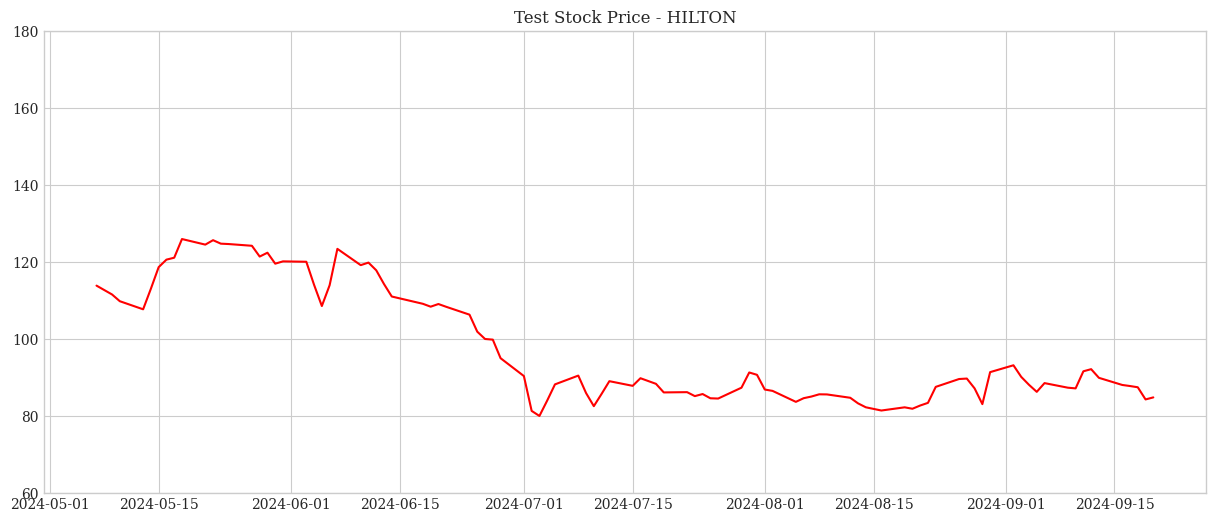

In [469]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.set_ylim([60,180]) # set the y-axis limits using set_ylim() to match the range from the plot where both lines are drawn.
axes.plot(df_SingleStock[len(df_train)+look_back:].index, y_test, color = 'red', label = 'Test Stock Price')
plt.title('Test Stock Price - ' + stocksymbol)


Text(0.5, 1.0, 'Predicted Stock Price - HILTON')

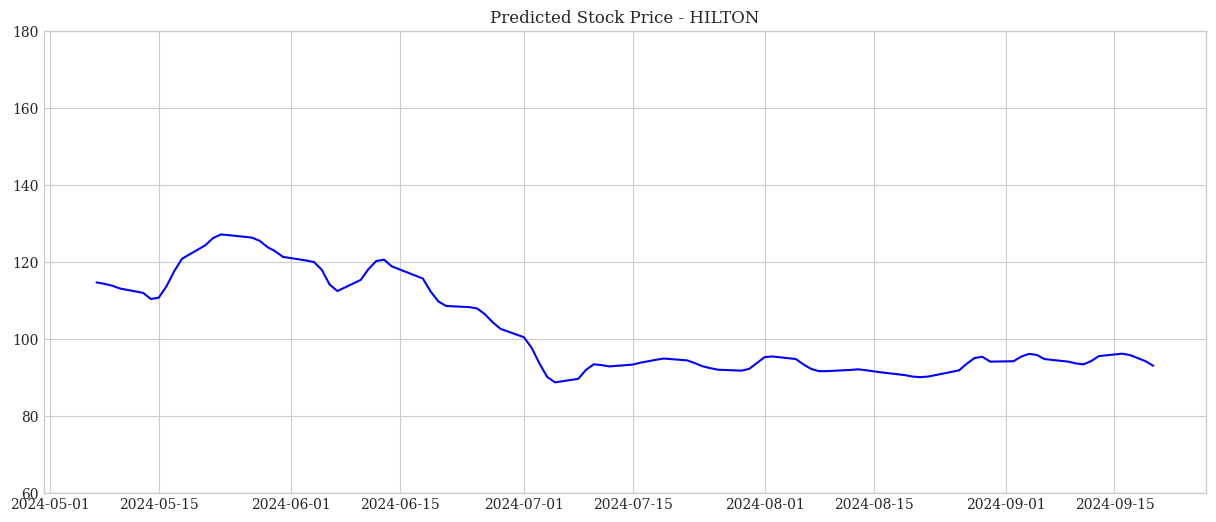

In [470]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.set_ylim([60,180]) # set the y-axis limits using set_ylim() to match the range from the plot where both lines are drawn.
axes.plot(df_SingleStock[len(df_train)+look_back:].index, y_test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Predicted Stock Price - ' + stocksymbol)


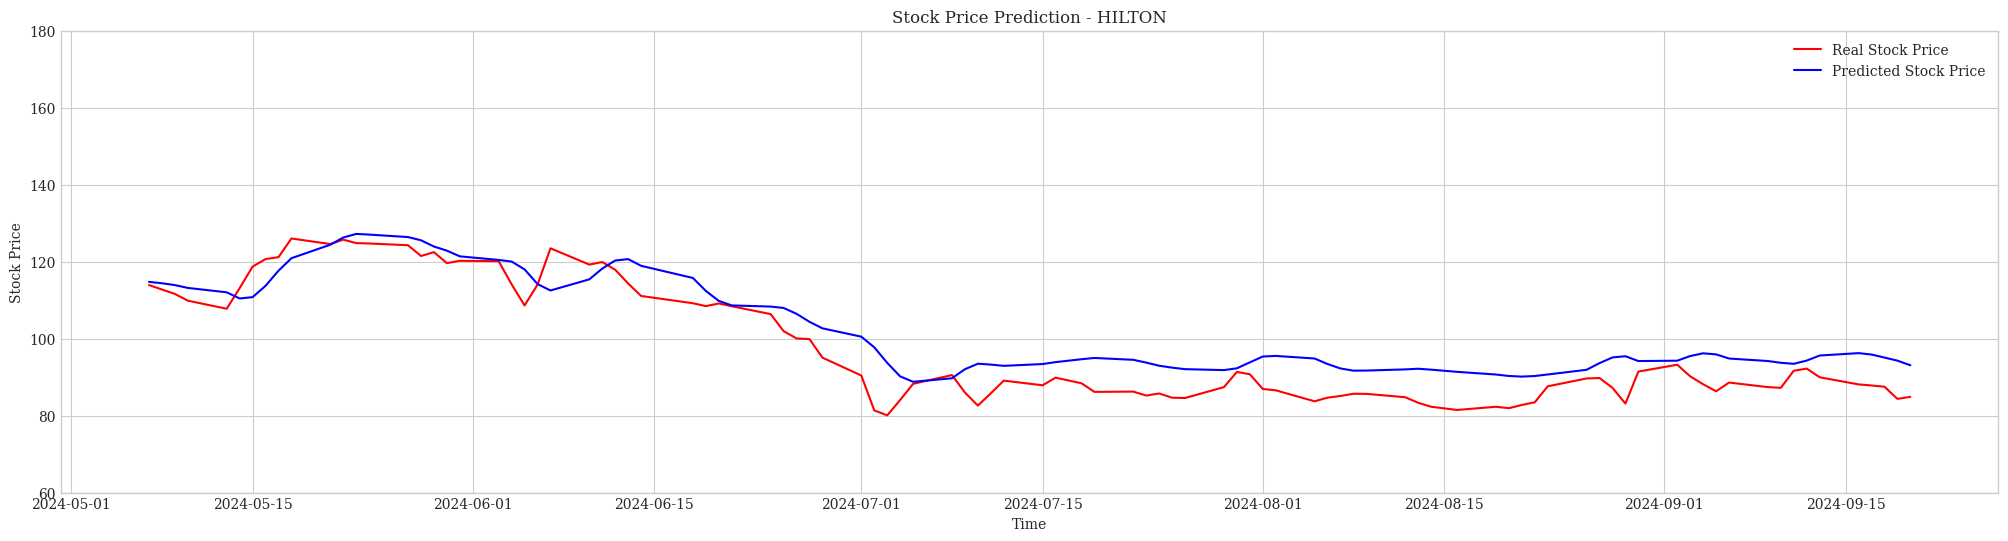

In [471]:
# Visualising the results
figure, axes = plt.subplots(figsize=(25, 6))
axes.xaxis_date()

axes.set_ylim([60,180]) # set the y-axis limits using set_ylim() to match the range from the plot where both lines are drawn.
axes.plot(df_SingleStock[len(df_SingleStock)-len(y_test):].index, y_test, color = 'red', label = 'Real Stock Price')
axes.plot(df_SingleStock[len(df_SingleStock)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Stock Price Prediction - ' + stocksymbol)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('pred.png')
plt.show()

In [472]:
# # Visualising the results
# figure, axes = plt.subplots(figsize=(15, 6))
# axes.xaxis_date()

# axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'red', label = 'Real IBM Stock Price')
# axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')
# #axes.xticks(np.arange(0,394,50))
# plt.title('IBM Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('IBM Stock Price')
# plt.legend()
# plt.savefig('ibm_pred.png')
# plt.show()